Valid rows for explainability: 7205 (removed 3 invalid target rows)
Saved permutation importance to: /Users/doananh/Documents/đồ án DS/explain_permutation.csv


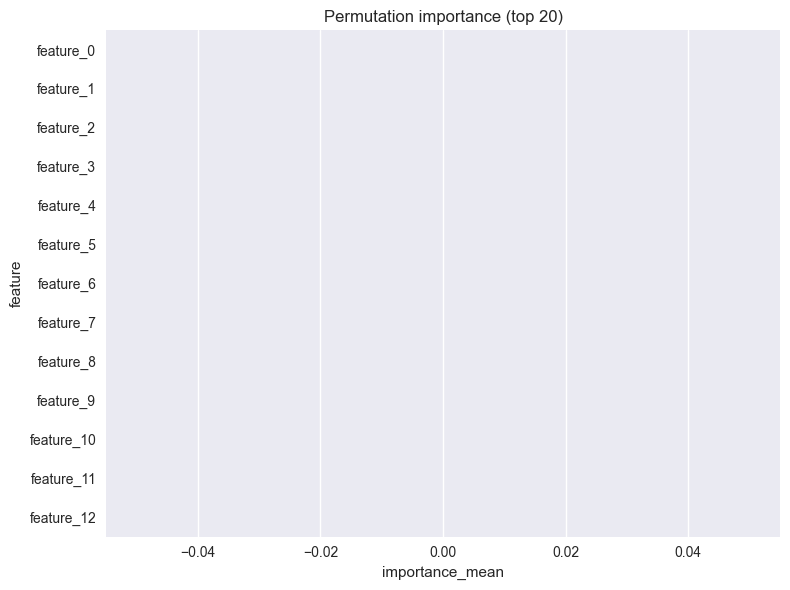

SHAP not available or unsupported model: SHAP not supported for this model type; skip.


In [2]:
# Explainability for Best Price Model: Permutation & SHAP (optional)

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.inspection import permutation_importance

plt.style.use('seaborn-v0_8')

DATA_DIR = Path('/Users/doananh/Documents/đồ án DS')
CLEAN = DATA_DIR / 'data_motobikes_clean.csv'
ART = DATA_DIR / 'artifacts'
MODELS = DATA_DIR / 'models'
PLOT_DIR = DATA_DIR / 'plots'
PLOT_DIR.mkdir(exist_ok=True)

Df = pd.read_csv(CLEAN, low_memory=False)
pre = joblib.load(ART / 'preprocessor.joblib')
preprocessor = pre['preprocessor']
NUMERIC = pre['numeric_features']
CATEG = pre['categorical_features']
TARGET = pre['target']

art = joblib.load(MODELS / 'price_model.joblib')
pipe = art['model']
X = Df[NUMERIC + CATEG].copy()
y = Df[TARGET].astype(float)

# Filter to rows with valid target (match training)
mask_valid = y.notna() & (y > 0)
X = X[mask_valid].copy()
y = y[mask_valid].copy()
print(f"Valid rows for explainability: {len(X)} (removed {len(Df) - len(X)} invalid target rows)")

if len(X) == 0:
    raise ValueError("No valid rows available for explainability after filtering.")

# Permutation Importance on a sample for speed
np.random.seed(42)
sample_size = min(5000, len(X))
sample_idx = np.random.choice(len(X), size=sample_size, replace=False)
Xs = X.iloc[sample_idx]
ys = y.iloc[sample_idx]

result = permutation_importance(pipe, Xs, ys, n_repeats=5, random_state=42, scoring='neg_mean_absolute_error')

# Map importances back to human-readable feature names
preprocessor = pipe.named_steps.get('pre')
if preprocessor is not None and hasattr(preprocessor, 'get_feature_names_out'):
    try:
        feature_names = np.array(preprocessor.get_feature_names_out())
    except Exception:
        feature_names = None
else:
    feature_names = None

n_features = result.importances_mean.shape[0]
if feature_names is None or feature_names.shape[0] != n_features:
    feature_names = np.array([f'feature_{i}' for i in range(n_features)])

pi_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})
pi_df = pi_df.sort_values('importance_mean', ascending=False)

pi_path = DATA_DIR / 'explain_permutation.csv'
pi_df.to_csv(pi_path, index=False)
print('Saved permutation importance to:', pi_path)

plt.figure(figsize=(8,6))
sns.barplot(data=pi_df.head(20), x='importance_mean', y='feature')
plt.title('Permutation importance (top 20)')
plt.tight_layout()
plt.savefig(PLOT_DIR / 'perm_importance_top20.png', dpi=150)
plt.show()

# SHAP (optional): works best with tree models. Try to compute on small sample.
try:
    import shap
    shap_explain_dir = PLOT_DIR
    # Extract underlying model after preprocessing
    model = pipe.named_steps['model']
    # Transform features
    Xt = pipe.named_steps['pre'].transform(Xs)
    explainer = None
    if model.__class__.__name__.lower().startswith('histgradientboosting'):
        explainer = shap.Explainer(model)
        shap_values = explainer(Xt)
    elif model.__class__.__name__.lower().startswith('randomforest'):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(Xt)
    else:
        raise RuntimeError('SHAP not supported for this model type; skip.')

    # Summary plot
    shap.summary_plot(shap_values, Xt, show=False)
    plt.tight_layout()
    plt.savefig(shap_explain_dir / 'shap_summary.png', dpi=150, bbox_inches='tight')
    plt.close()
    print('Saved SHAP summary plot.')
except Exception as e:
    print('SHAP not available or unsupported model:', e)

